# Import data

In [1]:
import cv2
import matplotlib.pyplot as plt

def imshow(filename):
  image = cv2.imread(filename)

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()
  print(image.shape)

In [2]:
path = 'Dataset/'

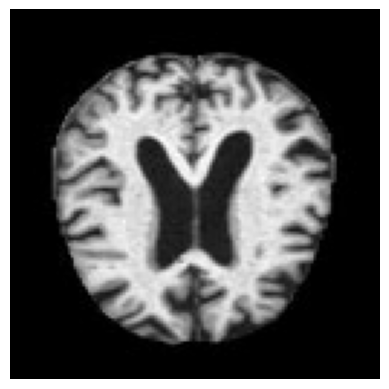

(128, 128, 3)


In [3]:
imshow(path+'Mild_Demented/mild.jpg')

# Image Preprocessing

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from PIL import Image
import numpy as np
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torchvision.disable_beta_transforms_warning()

## CustomDataset to import dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import copy
import random

class CustomDataset(Dataset):
    def __init__(self, root_dir, total_sample = 1000, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.total_sample = total_sample
        self.classes = os.listdir(root_dir)[1:]
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._get_images()
        self.class_count = self._get_class_count()
        self.images_splited_each_class = self._split_img_each_class()
        self.random_dataset = self.random_data()

    def _get_images(self):
        images = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            class_idx = self.class_to_idx[cls]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images
    
    def _get_class_count(self):
        class_count = {}
        for cls_name in self.class_to_idx.values():
            class_count[cls_name] = 0
        for key,value in self.images:
           class_count[value] += 1 
        return class_count
    
    def __len__(self):
        return len(self.random_dataset)
       
    def _get_labels(self):
        return [i[1] for i in self.images]
    
    def _split_img_each_class(self):
        data_class_split = {}
        for i in self.class_to_idx.values():
            data_class_split[i] = []
        for i in self.class_to_idx.values():
            for j in range(len(self.images)):
                if self.images[j][-1] == i:
                    data_class_split[i].append(self.images[j])
        return data_class_split
    
    def random_data(self):
        images_splited_each_class = copy.deepcopy(self.images_splited_each_class)
        random_list_idx = ['unknown'] + [i for i in range(len(self.classes))]
        allrandom_data = []

        for i in range(self.total_sample):
            random_data = []
            for class_idx in random_list_idx:
                if class_idx == 'unknown':
                    #unknown class
                    randclass = torch.randint(low=0, high=len(self.classes), size=(1,)).item()
                    random_img_unk = random.choice(images_splited_each_class[randclass])
                    random_data.append(random_img_unk)
                else:
                    #other class
                    random_img = random.choice(images_splited_each_class[class_idx])
                    random_data.append(random_img)
            allrandom_data.append(random_data)
        return allrandom_data

    def __getitem__(self, idx):
        data = self.random_dataset[idx]
        allrandom_img = []
        allrandom_label = []

        for img_path, label in data:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            allrandom_img.append(img)
            allrandom_label.append(label)

        return allrandom_img, allrandom_label

In [6]:
sample_data = CustomDataset(root_dir='Dataset')

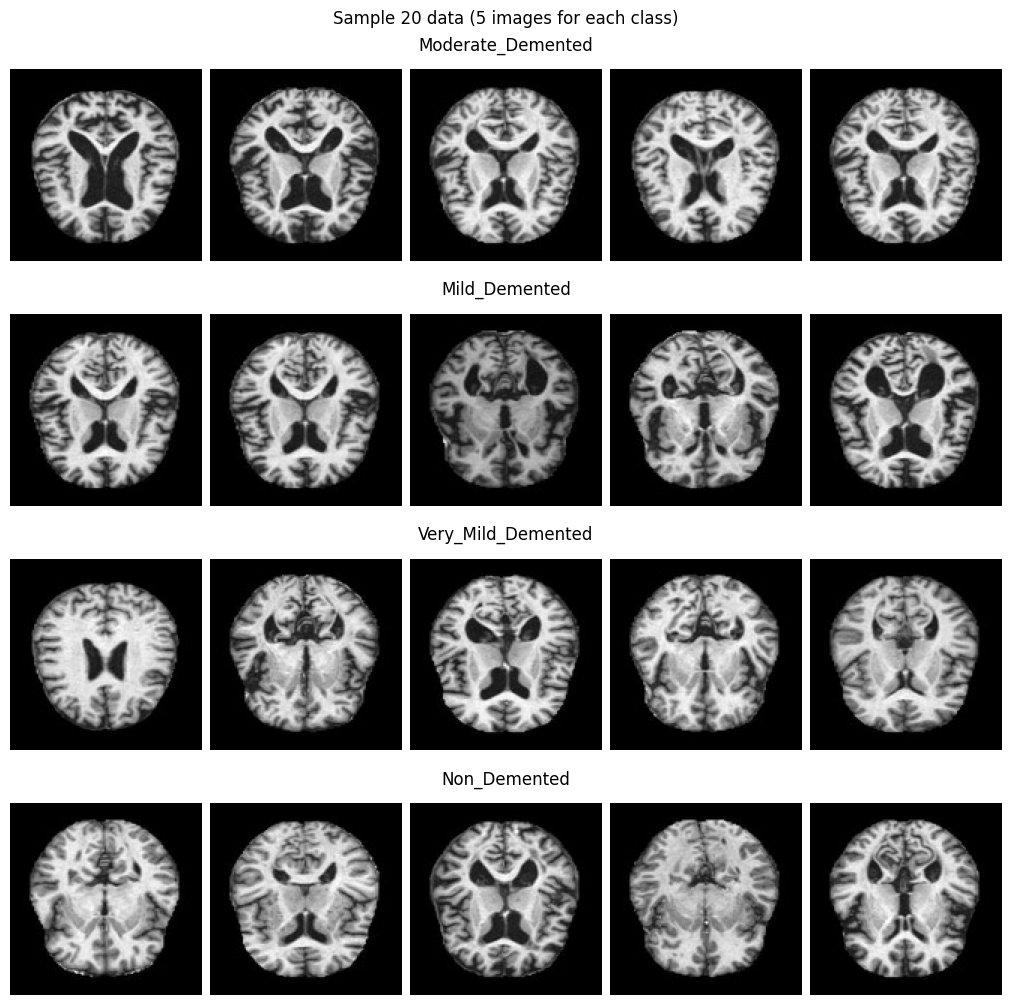

In [7]:
import matplotlib.image as mpimg
import copy

sample_data_dict = copy.deepcopy(sample_data.images_splited_each_class)

# create 4x1 subplots
fig, axs = plt.subplots(nrows=4, ncols=1, constrained_layout=True, figsize=(10, 10))
fig.suptitle('Sample 20 data (5 images for each class)')

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(zip(subfigs,sample_data.classes)):
    subfig[0].suptitle(subfig[-1])

    # create 1x5 subplots per subfig
    axs = subfig[0].subplots(nrows=1, ncols=5)

    for class_label, images in sample_data_dict.items():
        for i in range(5):
            img = mpimg.imread(images[i][0])
            axs[i].imshow(img,cmap='gray')
            axs[i].axis('off')
        break
 
    del sample_data_dict[class_label]

plt.show()

## Augmentation

### AddGaussianNoise

In [8]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, probability=0.5):
        self.std = std
        self.mean = mean
        self.probability = probability
        
    def __call__(self, tensor):
        if random.random() < self.probability:
            return tensor + (torch.randn(tensor.size()) * self.std) + self.mean
        else:
            return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

### Contrast-limited Adaptive Histogram Equalization (CLAHE)

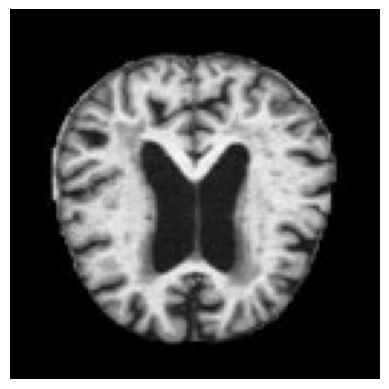

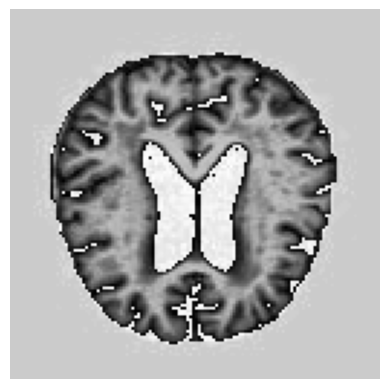

In [9]:
# Reading the image from the present directory
image = cv2.imread(path+'Mild_Demented/mild_2.jpg')
# Resizing the image for compatibility

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=3,tileGridSize=(1,1))
final_img = clahe.apply(image_bw) + 200
 
# Showing the two images
plt.imshow(cv2.cvtColor(image_bw, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
import cv2

class AddCLAHE():
    def __init__(self, clipLimit=3, tileGridSize=(1, 1), threshold=200) -> None:
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        self.threshold = threshold

    def __call__(self, tensor):
        tensor = tensor.numpy() * 255 
        tensor = tensor.astype('uint8')[0]

        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        transformed_tensor = clahe.apply(tensor)
        transformed_tensor = torch.from_numpy(transformed_tensor).float() + self.threshold
        transformed_tensor = transformed_tensor / 255
        transformed_tensor = transformed_tensor.unsqueeze(0)

        return transformed_tensor

    def __repr__(self):
        return self.__class__.__name__ + '(clipLimit={}, tileGridSize={}, threshold={})'.format(
            self.clipLimit, self.tileGridSize, self.threshold
        )

### Split white and gray matter

In [4]:
class split_white_and_gray():
    def __init__(self,threshold=120) -> None:
        self.threshold = threshold

    def __call__(self,tensor):
        tensor = (tensor*255).to(torch.int64)

        # Apply thresholding
        gray_matter = torch.where(tensor >= self.threshold,tensor,0)
        gray_matter = (gray_matter/255).to(torch.float64)
        white_matter = torch.where(tensor < self.threshold,tensor,0)
        white_matter = (white_matter/255).to(torch.float64)
        tensor = (tensor/255).to(torch.float64)

        return torch.cat((gray_matter, white_matter,tensor), dim=0)

# Prepare Dataset 

## Data transforms

In [5]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    split_white_and_gray(120),
    #AddCLAHE(),
    #AddGaussianNoise(0,0.05), 
])

In [6]:
import pickle
#Dataset = CustomDataset(root_dir='Dataset', total_sample=10000, transform=transform)

In [7]:
Dataset = pickle.load(open('Dataset.pkl', 'rb'))

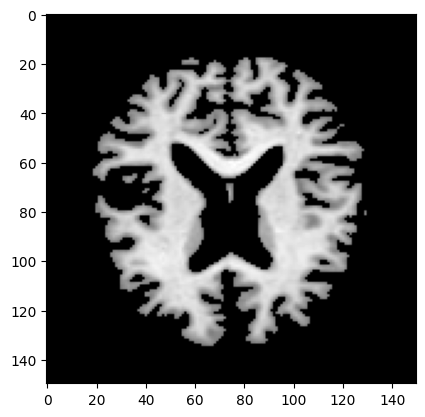

In [15]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][0][0]),cmap='gray')
plt.show()

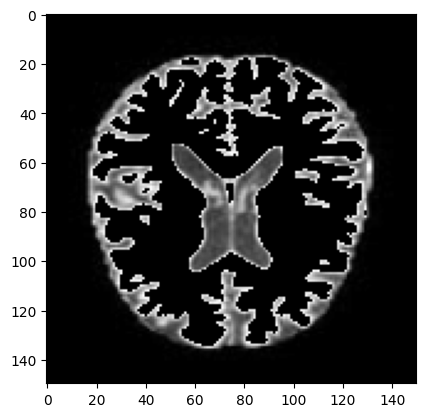

In [16]:
plt.imshow(transforms.ToPILImage()(Dataset[0][0][0][1]),cmap='gray')
plt.show()

## Split dataset 

In [17]:
from torch.utils.data import random_split

# Assuming you have a dataset named 'dataset' and it contains your data
dataset_size = len(Dataset)
train_size = int(0.45 * dataset_size)  # 70% for training
val_size = int(0.45 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size  # Remaining 15% for testing

train_dataset, val_test_dataset = random_split(Dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

## Over sampling method

In [18]:
def OverSample(Dataset):
    data = list(Dataset)
    class_count = {0:0, 1:0, 2:0, 3:0}
    for _, class_name in data:
        class_count[class_name] += 1

    # Calculate class weights for oversampling
    class_counts = list(class_count.values())
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

    # Assign weights to each sample based on its class
    
    weights = [class_weights[label] for _, label in data]

    # Create a WeightedRandomSampler to oversample minority classes
    sampler = WeightedRandomSampler(weights, 4000, replacement=True)

    return sampler

## Apply DataLoader

In [19]:
batch_size=64

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, )
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size,)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,)


In [19]:
train_dataloader = pickle.load(open('train_dataloader.pkl', 'rb'))
val_dataloader = pickle.load(open('val_dataloader.pkl', 'rb'))
test_dataloader = pickle.load(open('test_dataloader.pkl', 'rb'))

In [21]:
class_counts = {label: 0 for label in range(len(Dataset.classes))}

# Iterate through the DataLoader
for _, labels in train_dataloader:
    for label in labels[0]:
        class_counts[label.item()] += 1

# Print the counts
for label, count in class_counts.items():
    print(f"Class {label}: {count} items")

Class 0: 1143 items
Class 1: 1192 items
Class 2: 1047 items
Class 3: 1118 items


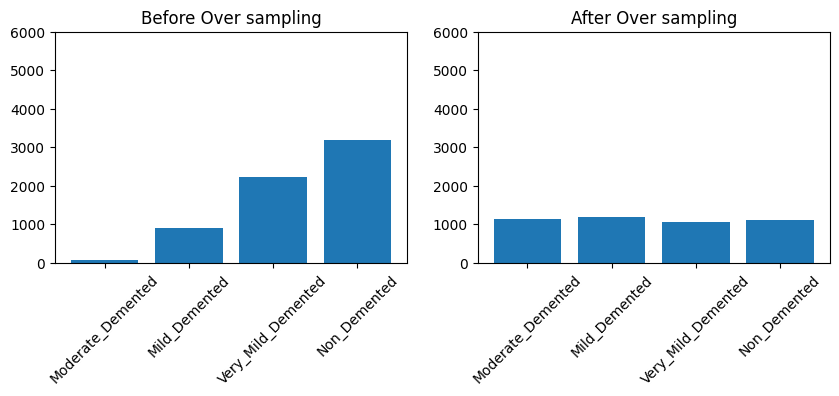

In [22]:
# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))  # Adjust the figsize as needed

# Add the first subplot
ax1.bar(Dataset.classes, Dataset.class_count.values())
ax1.set_xticks(range(len(Dataset.classes)))
ax1.set_xticklabels(Dataset.classes, rotation=45)
ax1.set_ylim(top=6000)
ax1.set_title("Before Over sampling")

# Add the second subplot
ax2.bar(Dataset.classes, class_counts.values())
ax2.set_xticks(range(len(Dataset.classes)))
ax2.set_xticklabels(Dataset.classes, rotation=45)
ax2.set_ylim(top=6000)
ax2.set_title("After Over sampling")

plt.show()


## visualization of each class

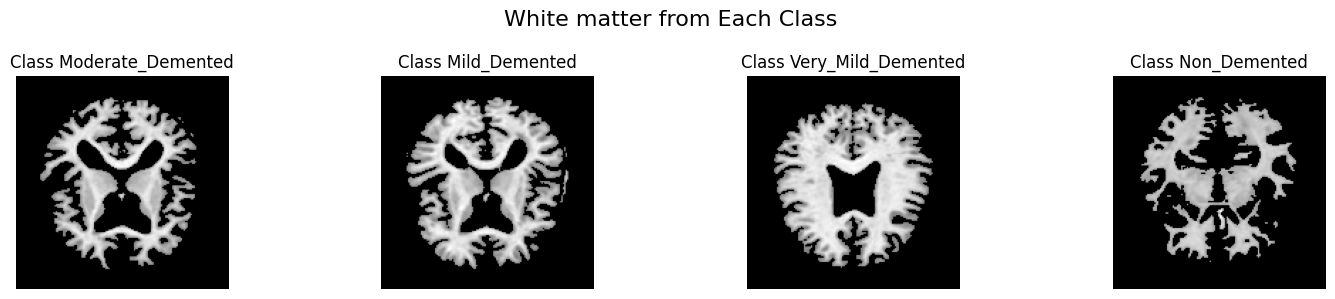

In [23]:
images, labels = next(iter(train_dataloader))

img_index = []
for label in labels[0].unique():
    img_index.append(list(labels[0]).index(label))

image_each_classes = []
for idx in img_index:
    image_each_classes.append(images[0][idx])

# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("White matter from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][0]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

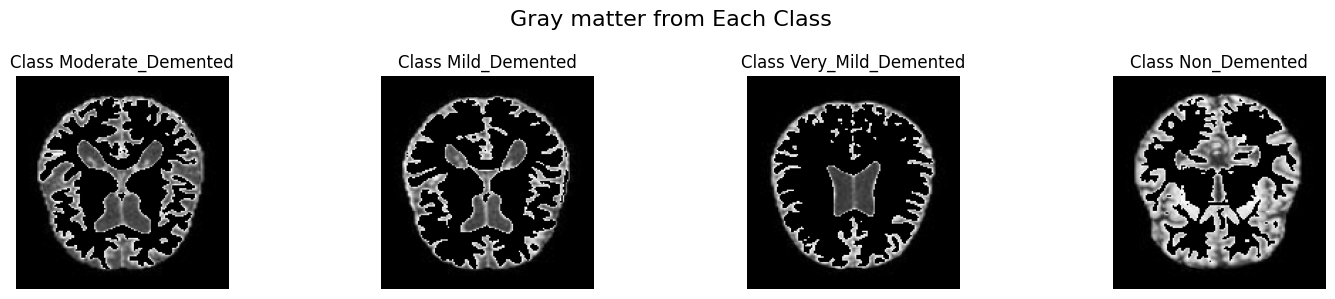

In [24]:
# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("Gray matter from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][1]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

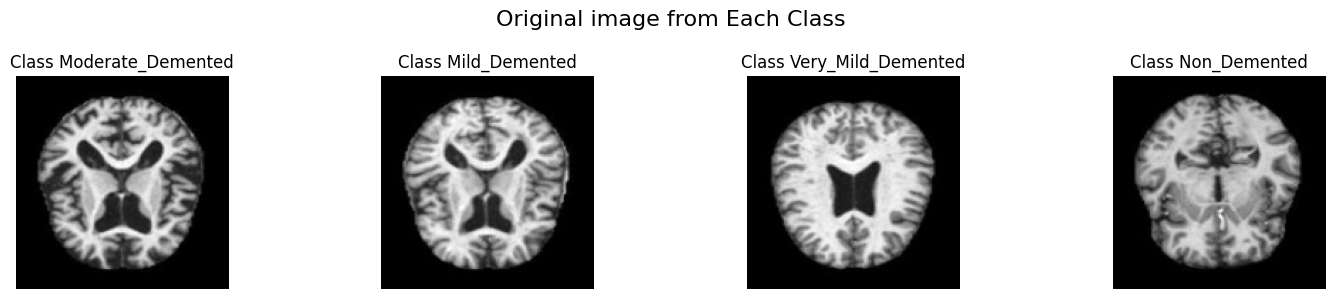

In [25]:
# Plot one image from each class
fig, axs = plt.subplots(1, len(Dataset.classes), figsize=(15, 3))
fig.suptitle("Original image from Each Class", fontsize=16)

for class_num, i in enumerate(zip(Dataset.classes,image_each_classes)):
    axs[class_num].imshow(transforms.ToPILImage()(i[-1][2]),cmap='gray')
    axs[class_num].set_title(f"Class {i[0]}")
    axs[class_num].axis('off')

plt.tight_layout()
plt.show()

# Backbone FeatureExtractor

class names : https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json,
https://github.com/anishathalye/imagenet-simple-labels/blob/master/imagenet-simple-labels.json

In [26]:
import requests

# Fetch the ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

labels[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead shark',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

## Resnet18

In [78]:
from torch.optim import lr_scheduler
import tqdm.notebook as tq
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import accuracy_score

def train(model:models, traindata:DataLoader, valdata:DataLoader) -> tuple:
    # training
    # Loop for training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    num_epochs = 50
    train_loss_history = []
    train_accuracy_history = []
    validation_loss_history = []
    validation_accuracy_history = []

    for epoch in tq.tqdm(range(num_epochs), desc="Epoch num", position=0, leave=True):
        # Train set
        running_loss = 0.0
        all_labels = []
        all_predictions = []

        # Val set
        val_running_loss = 0.0
        val_all_labels = []
        val_all_predictions = []

        # Use tqdm for progress visualization
        for i, data in enumerate(zip(traindata, valdata)):
            model.train()#change mode to training

            train_set, val_set = data
            inputs, labels = train_set

            optimizer.zero_grad()

            # Move inputs and labels to device
            inputs, labels = inputs[0].to(torch.float32).to(device), labels[0].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            # Track predictions for accuracy calculation
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            # Accumulate the loss
            running_loss += loss.item()
    #################################################################################################        
            # loss and acc on validation set
            model.eval() #change mode to evaluation
            with torch.no_grad():
                val_inputs, val_labels = val_set
                val_inputs, val_labels = val_inputs[0].to(torch.float32).to(device), val_labels[0].to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_predictions = torch.max(val_outputs, 1)
                val_all_labels.extend(val_labels.cpu().numpy())
                val_all_predictions.extend(val_predictions.cpu().numpy())

                val_running_loss += val_loss.item()
    #################################################################################################
        scheduler.step()

        # Calculate accuracy on training set
        accuracy = accuracy_score(all_labels, all_predictions)
        average_train_loss = running_loss / len(train_dataloader)
        train_loss_history.append(average_train_loss)
        train_accuracy_history.append(accuracy)

        # Calculate accuracy on validation set
        val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
        average_validation_loss = val_running_loss / len(val_dataloader)
        validation_loss_history.append(average_validation_loss)
        validation_accuracy_history.append(val_accuracy)
        
        # Print statistics for the epoch
        print("-------------------------------------------------------------------")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Training Loss   : {average_train_loss:.3f}  |  Training Accuracy   : {accuracy:.3f}")
        print(f"Validation Loss : {average_validation_loss:.3f}  |  Validation Accuracy : {val_accuracy:.3f}")
        print("-------------------------------------------------------------------")
        print()
    
    return train_loss_history, train_accuracy_history, validation_loss_history, validation_accuracy_history

### Transfer

In [8]:
import torch.nn as nn
import torchvision.models as models
import collections
import torch.optim as optim
from sklearn.metrics import accuracy_score

class Resnet18_backbone(nn.Module):
    def __init__(self):
        super(Resnet18_backbone, self).__init__()
        self.numclass =  4
        self.resnet18 = models.resnet18()
        self.resnet18_removelast = nn.Sequential(*list(self.resnet18.children())[:-1])
        self.classification_head = nn.Sequential(
                                                    nn.Linear(512, 256),  # Linear layer
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(256, 128),
                                                    nn.ReLU(inplace=True),
                                                    nn.Linear(128, self.numclass),
                                                    nn.Softmax(dim=1),
                                                )
        self.resnet18_backbone = nn.Sequential(
                                                    collections.OrderedDict(
                                                        [
                                                            ("resnet18", self.resnet18_removelast),
                                                            ("Flatten", nn.Flatten()),  # Flatten the output
                                                            ("BatchNorm", nn.BatchNorm1d(512)),  # Batch normalization
                                                            ("Head", self.classification_head),
                                                        ]
                                                    )
                                                )
        
    def forward(self, x):
        return self.resnet18_backbone(x)
    

In [29]:
# Move the model to device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
resnet18_backbone = Resnet18_backbone().to(torch.float32).to(device)

### Draw graph

In [30]:
# from torchviz import make_dot

# # Generate a visual representation of the model's computational graph
# x = torch.randn(1, 3, 150, 150)  # Example input
# y = resnet18_backbone(x)
# dot = make_dot(y, params=dict(resnet18_backbone.named_parameters()))

# # Save the generated graph as an image
# dot.render("your_model_graph")

### training

In [32]:
train_loss_history, train_accuracy_history, validation_loss_history, validation_accuracy_history = train(resnet18_backbone,train_dataloader,val_dataloader)

Epoch num:   0%|          | 0/50 [00:00<?, ?it/s]

-------------------------------------------------------------------
Epoch 1/50
Training Loss   : 1.121  |  Training Accuracy   : 0.615
Validation Loss : 1.387  |  Validation Accuracy : 0.327
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 2/50
Training Loss   : 1.088  |  Training Accuracy   : 0.648
Validation Loss : 1.254  |  Validation Accuracy : 0.482
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 3/50
Training Loss   : 1.057  |  Training Accuracy   : 0.677
Validation Loss : 1.213  |  Validation Accuracy : 0.522
-------------------------------------------------------------------

-------------------------------------------------------------------
Epoch 4/50
Training Loss   : 1.017  |  Training Accuracy   : 0.716
Validation Loss : 1.171  |  Validation Accuracy : 0.564
-----------------------------

### Loss and Acc on Training

In [33]:
import pickle

# Save variable to a file
# pickle.dump(train_loss_history, open('train_loss_history.pkl','wb'))
# pickle.dump(train_accuracy_history, open('train_accuracy_history.pkl','wb'))
# pickle.dump(validation_loss_history, open('validation_loss_history.pkl','wb'))
# pickle.dump(validation_accuracy_history, open('validation_accuracy_history.pkl','wb'))

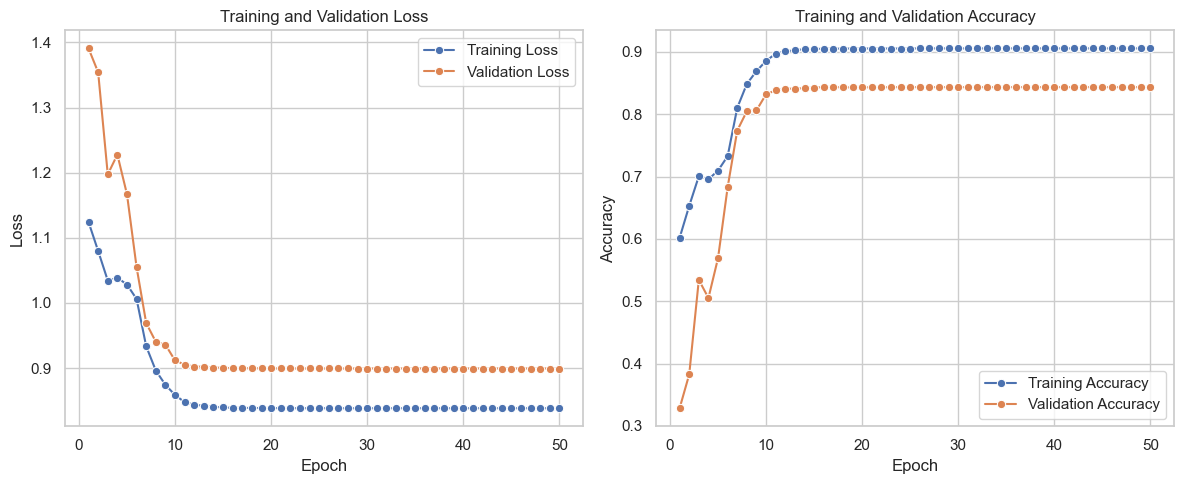

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

train_loss_history = pickle.load(open('train_loss_history.pkl', 'rb'))
train_accuracy_history = pickle.load(open('train_accuracy_history.pkl', 'rb'))
validation_loss_history = pickle.load(open('validation_loss_history.pkl', 'rb'))
validation_accuracy_history = pickle.load(open('validation_accuracy_history.pkl', 'rb'))

# Set the seaborn style
sns.set(style="whitegrid")

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the Loss
sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label='Training Loss', marker='o', ax=axes[0])
sns.lineplot(x=range(1, len(validation_loss_history) + 1), y=validation_loss_history, label='Validation Loss', marker='o', ax=axes[0])
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting the Accuracy
sns.lineplot(x=range(1, len(train_accuracy_history) + 1), y=train_accuracy_history, label='Training Accuracy', marker='o', ax=axes[1])
sns.lineplot(x=range(1, len(validation_accuracy_history) + 1), y=validation_accuracy_history, label='Validation Accuracy', marker='o', ax=axes[1])
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


#### On testset

In [43]:
import torch
from sklearn.metrics import accuracy_score

resnet18_backbone.eval()
test_all_labels = []
test_all_predictions = []
test_running_loss = 0.0

criterion = nn.CrossEntropyLoss()

for test_inputs, test_labels in tq.tqdm_notebook(test_dataloader):
    with torch.no_grad():
        test_inputs, test_labels = test_inputs[0].to(torch.float32).to(device), test_labels[0].to(device)

        test_outputs = resnet18_backbone(test_inputs)
        test_loss = criterion(test_outputs, test_labels)

        _, test_predictions = torch.max(test_outputs, 1)
        test_all_labels.extend(test_labels.cpu().numpy())
        test_all_predictions.extend(test_predictions.cpu().numpy())

        test_running_loss += test_loss.item()

# Calculate accuracy after the loop
test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
average_test_loss = test_running_loss / len(test_dataloader)


  0%|          | 0/16 [00:00<?, ?it/s]

### Summary

In [44]:
import pandas as pd
df = pd.DataFrame({'Loss':[train_loss_history[-1],validation_loss_history[-1],average_test_loss], 
                   'Accuracy':[train_accuracy_history[-1]*100, validation_accuracy_history[-1]*100, test_accuracy*100]})
df = df.set_axis(['Train', 'Validation', 'Test'])
df

,Loss,Accuracy
Train,0.838202,90.555556
Validation,0.899248,84.333333
Test,0.889995,85.400000


### Save model

In [45]:
#torch.save(resnet18_backbone, "resnet18_backbone.pth")

In [10]:
loaded_model = torch.load("resnet18_backbone.pth")

### Siamese Model with Hyperclass method

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class SiameseNetwork_Resnet18(nn.Module):
    def __init__(self):
        super(SiameseNetwork_Resnet18, self).__init__()
        self.loaded_model = torch.load("resnet18_backbone.pth")
        self.resnet18_backbone = nn.Sequential(*list(self.loaded_model.children())[-1][:-1],)
                                               #nn.Sequential(list(self.loaded_model.children())[-1][-1][:-1]))

        # Freeze all layers 
        for param in self.resnet18_backbone.parameters():
            param.requires_grad = False

    def forward_once(self, x):
        return self.resnet18_backbone(x)
    
    def softmax_with_dropout(self, logits, dropout_percentage=0.2):
        logits = logits.clone()

        # Calculate the number of values to drop
        num_values_to_drop = int(round(dropout_percentage * 2))

        # Get the indices of the lowest values
        _, indices = torch.topk(logits, num_values_to_drop, largest=False)
        logits[indices] = float('-inf')

        # Apply softmax
        softmax_output = F.softmax(logits, dim=0)

        return softmax_output


    def forward(self, unknown_input, *hyperclass):
        # Calculate cosine similarity matrix
        outputs = torch.stack([self.forward_once(inp) for inp in hyperclass], dim=1)
        similarities = F.cosine_similarity(
            self.resnet18_backbone(unknown_input)[:, None, :], outputs, dim=2
        )
        
        probability = torch.stack([self.softmax_with_dropout(row) for row in similarities])

        return probability

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
smr = SiameseNetwork_Resnet18().to(torch.float32).to(device)

In [42]:
import torch
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp
import copy
import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

hyperclass = copy.deepcopy(Dataset.images_splited_each_class)

hyperclass_space = {}
for idx, val in hyperclass.items():
    img_all_path = []
    for imgpath, _ in val:
        img_all_path.append(imgpath)
    hyperclass_space[idx] = img_all_path

space = {
    "class_o": hp.choice("class_o", hyperclass_space[0]),
    "class_1": hp.choice("class_1", hyperclass_space[1]),
    "class_2": hp.choice("class_2", hyperclass_space[2]),
    "class_3": hp.choice("class_3", hyperclass_space[3]),
}

def objective_function(paramspace, testset=test_dataloader, model=None, transform=transform):
    model.eval()

    def read_image(img_path):
        img = Image.open(img_path).convert('RGB')

        if transform:
            img = transform(img)

        return img

    class_0, class_1, class_2, class_3 = (
        paramspace['class_o'],
        paramspace['class_1'],
        paramspace['class_2'],
        paramspace['class_3'],
    )

    class_0, class_1, class_2, class_3 = (
        read_image(class_0),
        read_image(class_1),
        read_image(class_2),
        read_image(class_3),
    )

    test_all_labels = []
    test_all_predictions = []

    for test_inputs, test_labels in testset:
        duplicated_tensor_1 = class_0.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_2 = class_1.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_3 = class_2.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_4 = class_3.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)

        with torch.no_grad():
            test_inputs, test_labels = (
                test_inputs[0].to(torch.float32).to(device),
                test_labels[0].to(device),
            )
            test_outputs = model(
                test_inputs,
                duplicated_tensor_1,
                duplicated_tensor_2,
                duplicated_tensor_3,
                duplicated_tensor_4,
            )

            _, test_predictions = torch.max(test_outputs, 1)
            test_all_labels.extend(test_labels.cpu().numpy())
            test_all_predictions.extend(test_predictions.cpu().numpy())

    test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
    acc_loss = 1 - test_accuracy

    return acc_loss

# Minimize the objective function using the Tree-structured Parzen Estimators (TPE) algorithm
best_params = fmin(
    fn=lambda params: objective_function(params, model=smr), 
    space=space, 
    algo=tpe.suggest, 
    max_evals=50
)


 72%|███████▏  | 36/50 [30:20<11:48, 50.58s/trial, best loss: 0.17000000000000004] 


KeyboardInterrupt: 

In [41]:
best_params

{'class_1': 160.29940513066705,
 'class_2': 1482.4784389570646,
 'class_3': 709.8440219976211,
 'class_o': 14.263162512536647}

In [39]:
import torch
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization
import copy

hyperclass = copy.deepcopy(Dataset.images_splited_each_class)

hyperclass_space = {}
for idx, val in hyperclass.items():
    img_all_path = []
    for imgpath, _ in val:
        img_all_path.append(imgpath)
    hyperclass_space[idx] = img_all_path

space = {
    "class_o": (0, len(hyperclass_space[0]) - 1),
    "class_1": (0, len(hyperclass_space[1]) - 1),
    "class_2": (0, len(hyperclass_space[2]) - 1),
    "class_3": (0, len(hyperclass_space[3]) - 1),
}

def objective_function(class_o, class_1, class_2, class_3, testset=test_dataloader, model=smr, transform=transform):
    model.eval()

    def read_image(img_path):
        img = Image.open(img_path).convert('RGB')

        if transform:
            img = transform(img)

        return img

    class_0, class_1, class_2, class_3 = (
        hyperclass_space[0][int(class_o)],
        hyperclass_space[1][int(class_1)],
        hyperclass_space[2][int(class_2)],
        hyperclass_space[3][int(class_3)],
    )

    class_0, class_1, class_2, class_3 = (
        read_image(class_0),
        read_image(class_1),
        read_image(class_2),
        read_image(class_3),
    )

    test_all_labels = []
    test_all_predictions = []

    for test_inputs, test_labels in testset:
        duplicated_tensor_1 = class_0.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_2 = class_1.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_3 = class_2.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)
        duplicated_tensor_4 = class_3.repeat(test_inputs[0].shape[0], 1, 1, 1).to(torch.float32).to(device)

        with torch.no_grad():
            test_inputs, test_labels = (
                test_inputs[0].to(torch.float32).to(device),
                test_labels[0].to(device),
            )
            test_outputs = model(
                test_inputs,
                duplicated_tensor_1,
                duplicated_tensor_2,
                duplicated_tensor_3,
                duplicated_tensor_4,
            )

            _, test_predictions = torch.max(test_outputs, 1)
            test_all_labels.extend(test_labels.cpu().numpy())
            test_all_predictions.extend(test_predictions.cpu().numpy())

    test_accuracy = accuracy_score(test_all_labels, test_all_predictions)
    acc_loss = test_accuracy

    return acc_loss

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=space,
    random_state=42,  # Set a random seed for reproducibility
)

# Maximize the objective function using Bayesian Optimization
optimizer.maximize(
    init_points=5,  # Number of random points to initialize the optimization
    n_iter=45,      # Number of optimization steps
)

# Get the best hyperparameters
best_params = optimizer.max['params']


|   iter    |  target   |  class_1  |  class_2  |  class_3  |  class_o  |
-------------------------------------------------------------------------
| 1         | 0.632     | 335.2     | 2.129e+03 | 2.342e+03 | 37.72     |
| 2         | 0.822     | 139.6     | 349.3     | 185.8     | 54.57     |
| 3         | 0.62      | 538.0     | 1.585e+03 | 65.85     | 61.1      |
| 4         | 0.516     | 745.0     | 475.4     | 581.7     | 11.55     |
| 5         | 0.603     | 272.3     | 1.175e+03 | 1.382e+03 | 18.35     |
| 6         | 0.783     | 647.2     | 1.496e+03 | 712.8     | 4.025     |
| 7         | 0.794     | 44.05     | 41.38     | 1.921e+03 | 45.6      |
| 8         | 0.619     | 4.008     | 90.38     | 1.492e+03 | 22.18     |
| 9         | 0.593     | 868.9     | 1.589e+03 | 3.179e+03 | 23.56     |
| 10        | 0.787     | 422.0     | 359.3     | 2.565e+03 | 6.08      |
| 11        | 0.784     | 839.8     | 1.581e+03 | 1.44e+03  | 62.9      |
| 12        | 0.799     | 693.8     | 

In [40]:
optimizer.max

{'target': 0.832,
 'params': {'class_1': 160.29940513066705,
  'class_2': 1482.4784389570646,
  'class_3': 709.8440219976211,
  'class_o': 14.263162512536647}}

## FeatureExtractor

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Define a custom model with a CNN backbone for feature extraction
class FeatureExtractor(nn.Module):
    def __init__(self, cnn_backbone):
        super(FeatureExtractor, self).__init__()
        # Use the specified CNN backbone
        self.cnn_backbone = cnn_backbone

    def forward(self, x):
        # Forward pass through the CNN backbone to obtain feature maps
        features = self.cnn_backbone(x)
        return features

# Load a pre-trained ResNet18 model
resnet18 = models.resnet18()

# Remove the final fully connected layers for classification
# to get the feature extraction backbone
feature_extraction_backbone = nn.Sequential(*list(resnet18.children())[:-2])

# Create an instance of the FeatureExtractor using ResNet18 backbone
feature_extractor = FeatureExtractor(feature_extraction_backbone)

# Set the model to evaluation mode
feature_extractor.eval()

FeatureExtractor(
  (cnn_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
# Perform feature extraction
with torch.no_grad():
    extracted_features = feature_extractor(images[0].unsqueeze(0).to(torch.float32))

# Print the shape of the extracted features
print(extracted_features.shape)


torch.Size([1, 512, 5, 5])


# torchvision feature extraction

credit : https://github.com/alexander-soare/torchvision_feature_extraction_walkthrough/blob/main/notebook.ipynb?fbclid=IwAR3J_jzbGtoChdH20zGemBxqpeJWqoCttwnamx65Bzov57qWHcil_CpzbTg

youtube : https://www.youtube.com/watch?v=QRQBTkCLpFY&t=1592s

## Def files

In [ ]:
import torch
import numpy as np

def prepare(img, mean, std):
    img = img / 255.
    img = img - np.array(mean)
    img = img / np.array(std)
    return torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()

In [ ]:
from typing import Union, Tuple

import cv2
import numpy as np


def center_crop(img: np.ndarray, crop_size: Tuple[int, int]) -> np.ndarray:
    """
    Args:
        img - Image to be cropped
        crop_size - Size of crop. Must be smaller than or equal to the image
            size
    """
    assert (img.shape[0] >= crop_size[0]) and (img.shape[1] >= crop_size[1])
    y0 = img.shape[0] // 2 - crop_size[0] // 2
    y1 = y0 + crop_size[0]
    x0 = img.shape[1] // 2 - crop_size[1] // 2
    x1 = x0 + crop_size[1]
    return img.copy()[y0:y1, x0:x1]


def resize_shortest_edge(
        img: np.ndarray, length: int,
        interpolation: Union[int, str]=cv2.INTER_LINEAR) -> np.ndarray:
    """
    Resize image with locked aspect ratio such that its shortest side is `length`
    pixels long.
    `interpolation` specifies the cv2 interpolation type and defaults to
    cv2.INTER_LINERAR It may be specified as 'auto' in which case either
    cv2.INTER_AREA or cv2.INTERCUBIC is used depnding on whether we are
    downsizing or upsizing (respectively)
    """
    f = length/np.min(img.shape[:2])
    if isinstance(interpolation, str):
        assert interpolation == 'auto', \
            "If `interpolation` is a str it can only be 'auto'"
        interpolation = cv2.INTER_AREA if f < 1 else cv2.INTER_CUBIC
    return cv2.resize(img, (0,0), fx=f, fy=f, interpolation=interpolation)

In [ ]:
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np


def show_images(ls_img, titles=[], imsize=(7, 5), cmap=None, per_row=2,
                keep_ticks=False, font_size=16):
    """makes a figure with enough subplots to show the images of `ls_img`
    """                
    # make sure ls_img is a list
    if not isinstance(ls_img, Sequence):
        ls_img = [ls_img]

    # make sure titles is a list
    if not isinstance(titles, Sequence):
        titles = [titles]

    # make sure titles is same length as ls_img
    if len(titles):
        assert len(titles) == len(
            ls_img), "Please provide as many titles as there are images"
    else:
        titles = [''] * len(ls_img)

    # prepare figure
    num_rows = len(ls_img) // per_row + ((len(ls_img) % per_row) > 0)
    fig, ax = plt.subplots(num_rows, per_row, figsize=(
        imsize[0] * per_row, imsize[1] * num_rows))
    if type(ax) == np.ndarray:
        ax = ax.flatten()
    else:
        ax = np.array([ax])

    # populate figure
    for i, img in enumerate(ls_img):
        this_cmap = cmap
        if this_cmap is None and (len(img.shape) == 2 or img.shape[-1] == 1):
            this_cmap = 'gray'
        ax[i].imshow(img, cmap=this_cmap, vmin=0, vmax=255)
        ax[i].set_title(titles[i], fontdict={'fontsize': font_size})
        if not keep_ticks:
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    return fig, ax

## Perform backbone from timm

In [ ]:
import timm

model = timm.create_model('resnest50d',pretrained=True)
model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNestBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (con

In [ ]:
model.get_classifier()

Linear(in_features=2048, out_features=1000, bias=True)

(<Figure size 500x500 with 1 Axes>, array([<Axes: >], dtype=object))

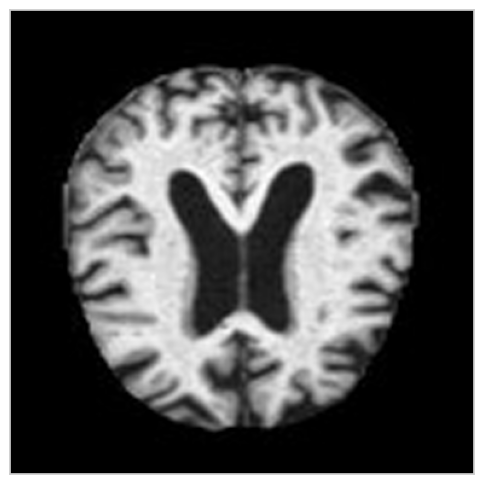

In [ ]:
imgs = []

for file_path in [path+'Mild_Demented/mild.jpg']:
    img = cv2.imread(file_path)[..., ::-1]
    img = resize_shortest_edge(img, 384, interpolation='auto')
    img = center_crop(img, (384, 384))
    imgs.append(img)

show_images(imgs, per_row=1, imsize=(5, 5))

In [ ]:
import torch

inps = [prepare(img, model.default_cfg['mean'], model.default_cfg['std'])
        for img in imgs]

with torch.no_grad():
    out = torch.softmax(model(inps[0]), -1)[0].numpy()

print(out.argmax())

117


In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
from pprint import pprint

train_nodes, eval_nodes = get_graph_node_names(model)

assert([t == e for t, e in zip(train_nodes, eval_nodes)])

pprint(train_nodes[0:5])

['x', 'conv1.0', 'conv1.1', 'conv1.2', 'conv1.3']


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


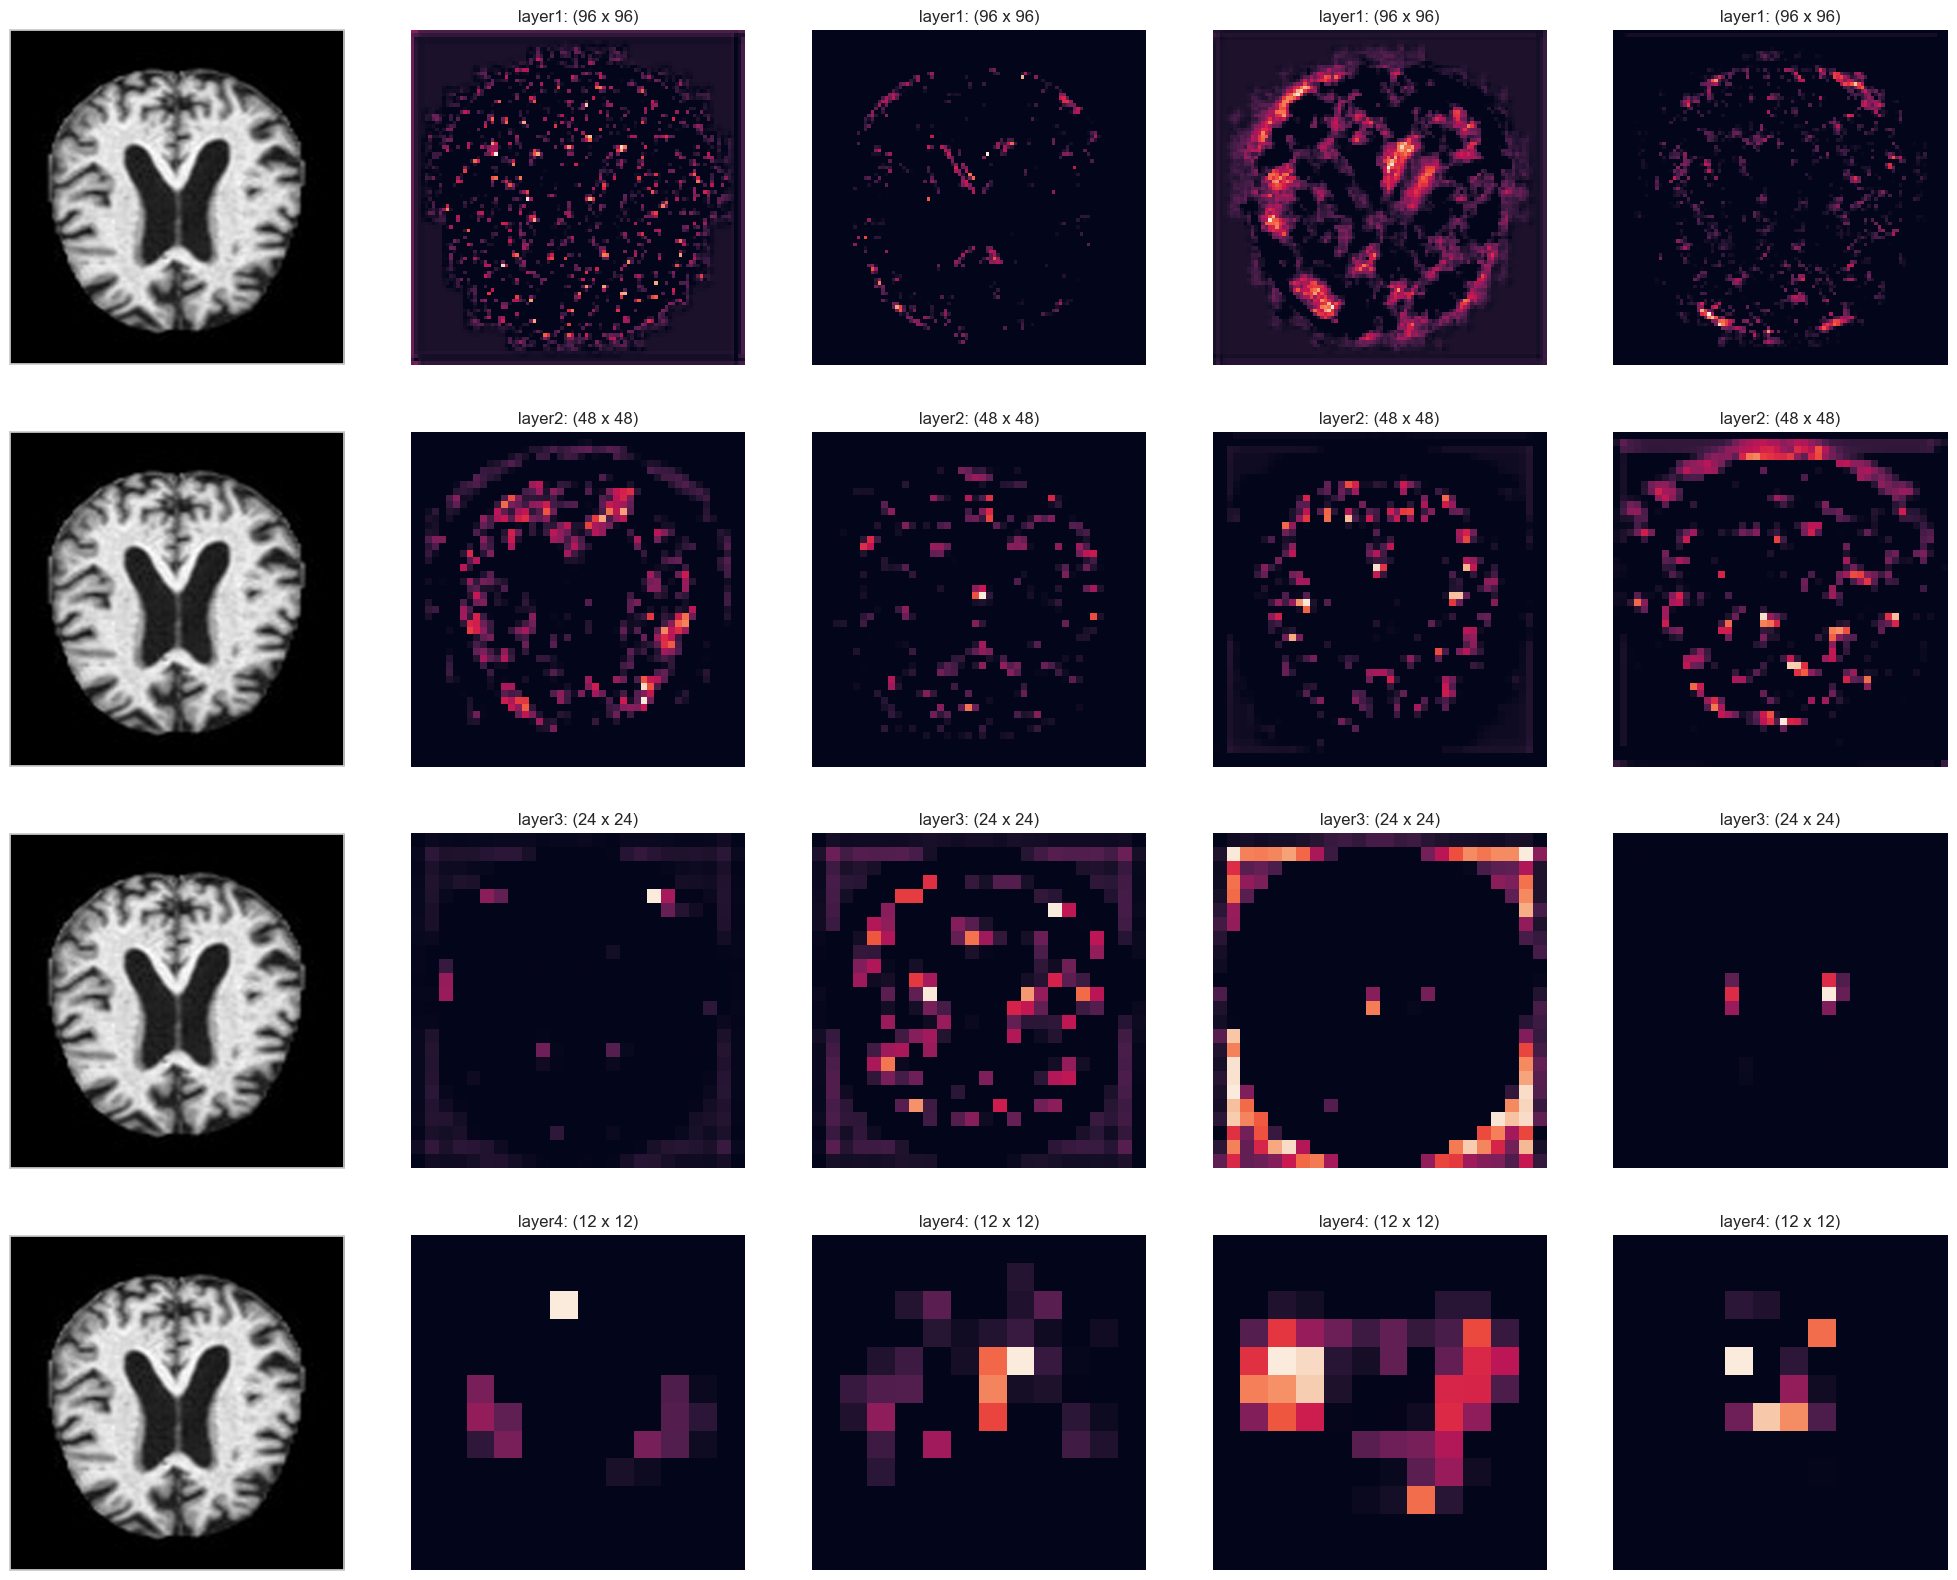

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor
import random
import seaborn as sns
import matplotlib.pyplot as plt

return_nodes = ['layer1', 'layer2', 'layer3', 'layer4']

feat_ext = create_feature_extractor(model, return_nodes=return_nodes)

with torch.no_grad():
    out = feat_ext(inps[0])

fig, ax = plt.subplots(4, 5, figsize=(25, 20))

# Pick 4 random feature maps from each layer
for i, layer in enumerate(return_nodes):
    feat_maps = out[layer].numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    ax[i][0].imshow(imgs[0])
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        sns.heatmap(feat_map, ax=ax[i][j+1], cbar=False)
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')